# Introduction

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import bk.load
import bk.compute
import bk.plot
import bk.signal
import bk.io

import scipy as sp
import scipy.signal

import neuroseries as nts
%matplotlib inline

In [2]:
bk.load.current_session_linux(base_folder= '/mnt/electrophy/Gabrielle/GG-Dataset-Light/',local_path='Rat08/Rat08-20130713')

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713


True

In [4]:
print('Rat : ',bk.load.rat)
print('Day : ',bk.load.day)
print('Path : ',bk.load.path)
print('Name of session : ', bk.load.session)

Rat :  8
Day :  6
Path :  /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713
Name of session :  Rat08-20130713


# LFPs

## Load LFP / Filter LFP

In [6]:
lfp = bk.load.lfp(23)

In [7]:
f,t,sxx = scipy.signal.spectrogram(lfp.values,1250,nperseg = 5000,noverlap = 2500)
t = t+lfp.as_units('s').index.values[0]

In [8]:
theta_mask = (5<f) & (f<10)
delta_mask = (0.1<f) & (f<4)

In [9]:
theta_power = np.mean(sxx[theta_mask,:],axis = 0)
delta_power = np.mean(sxx[delta_mask,:],axis = 0)

In [10]:
ratio = theta_power / delta_power

In [13]:
rec_interval = nts.IntervalSet(lfp.index.values[0],lfp.index.values[-1])


In [14]:
theta_on = ratio > 1.2
theta_intervals = bk.compute.toIntervals(t,theta_on,'s')
theta_intervals = theta_intervals.merge_close_intervals(15,'s')

delta_intervals = rec_interval.set_diff(theta_intervals)

In [15]:
del lfp
acc = bk.load.lfp(160)

In [18]:
sleep = acc.values < 20 
sleep_intervals = bk.compute.toIntervals(acc.index.values,sleep)
sleep_intervals = sleep_intervals.drop_short_intervals(30,'s').reset_index(drop = True)


rec_interval = nts.IntervalSet(acc.index.values[0],acc.index.values[-1])
wake_intervals = rec_interval.set_diff(sleep_intervals)

In [19]:
rem_intervals = sleep_intervals.intersect(theta_intervals)
nrem_intervals = sleep_intervals.intersect(delta_intervals)

In [112]:
%matplotlib qt
fig,ax = plt.subplots(3,1,sharex=True,dpi = 200)
ax[0].plot(lfp.as_units('s'))

plt.sca(ax[0])
bk.plot.intervals(wake_intervals,'red')
bk.plot.intervals(rem_intervals,'orange')
bk.plot.intervals(nrem_intervals,'grey')
ax[1].plot(acc.as_units('s'),'r')



ax[2].pcolor(t,f,np.log(sxx),vmin = 0,vmax = 12)
ax[2].set_ylabel('Freq')
ax[2].set_xlabel('Time')
ax[2].set_ylim(0,20)
ax[2].plot(t,ratio,'w')

/tmp/ipykernel_24866/2675984742.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[2].pcolor(t,f,np.log(sxx),vmin = 0,vmax = 12)


In [22]:
wake_intervals['state'] = 'WAKE'
nrem_intervals['state'] = 'NREM'
rem_intervals['state']='REM'
pd.concat((wake_intervals,nrem_intervals,rem_intervals)).reset_index(drop=True).to_csv('sleep_scoring_automatic.csv')

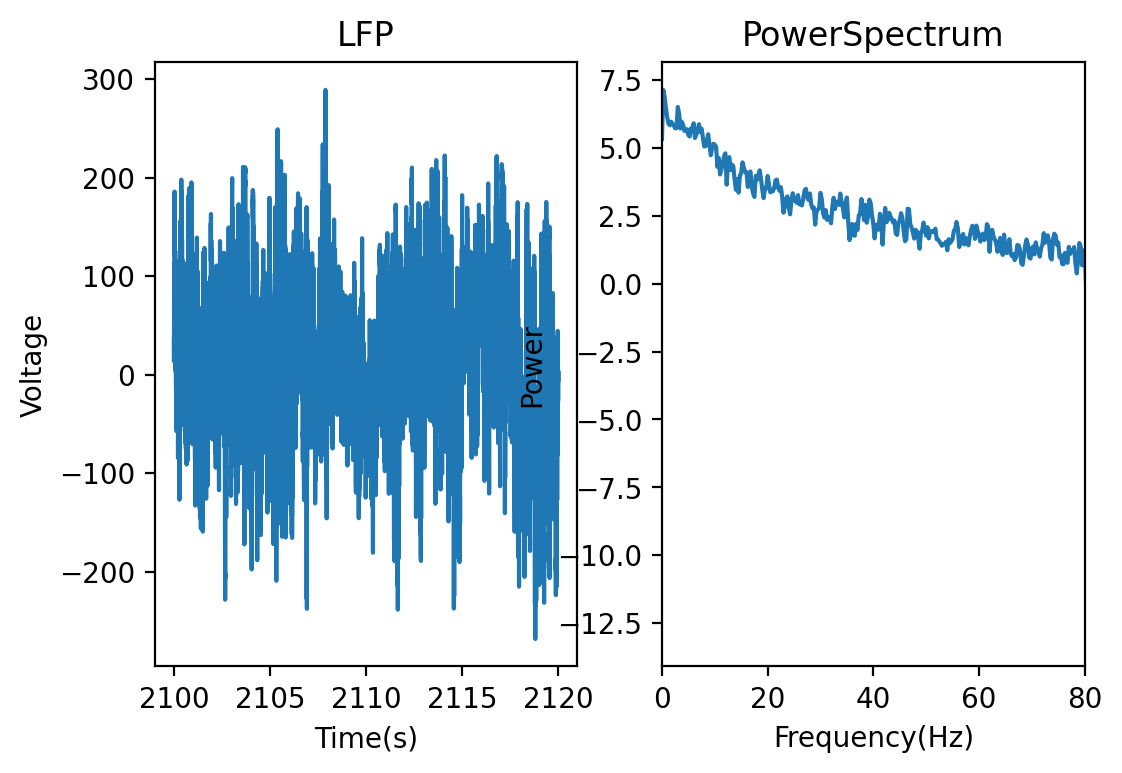

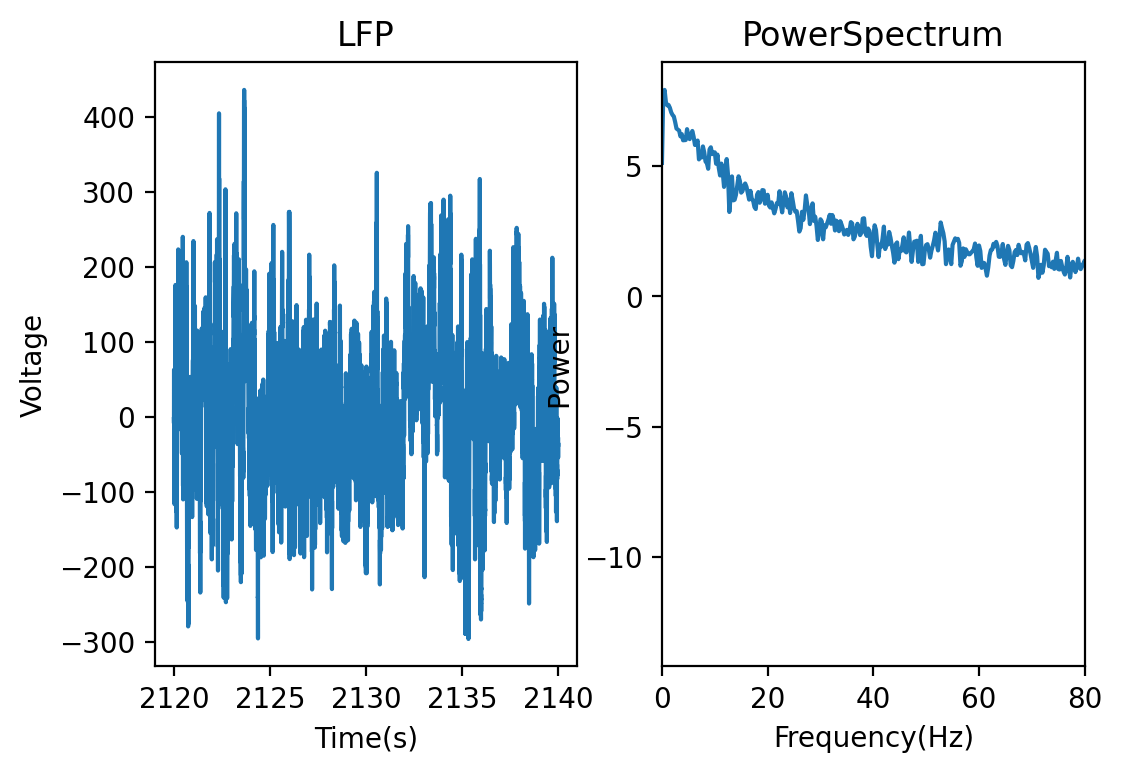

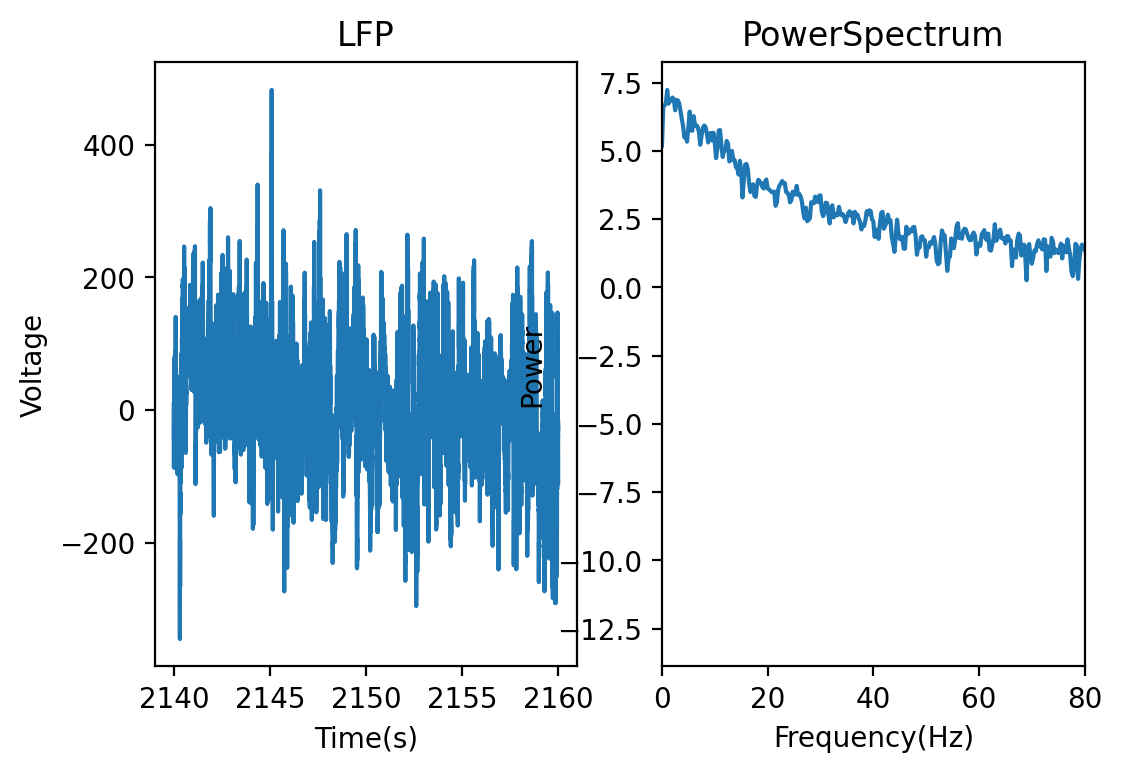

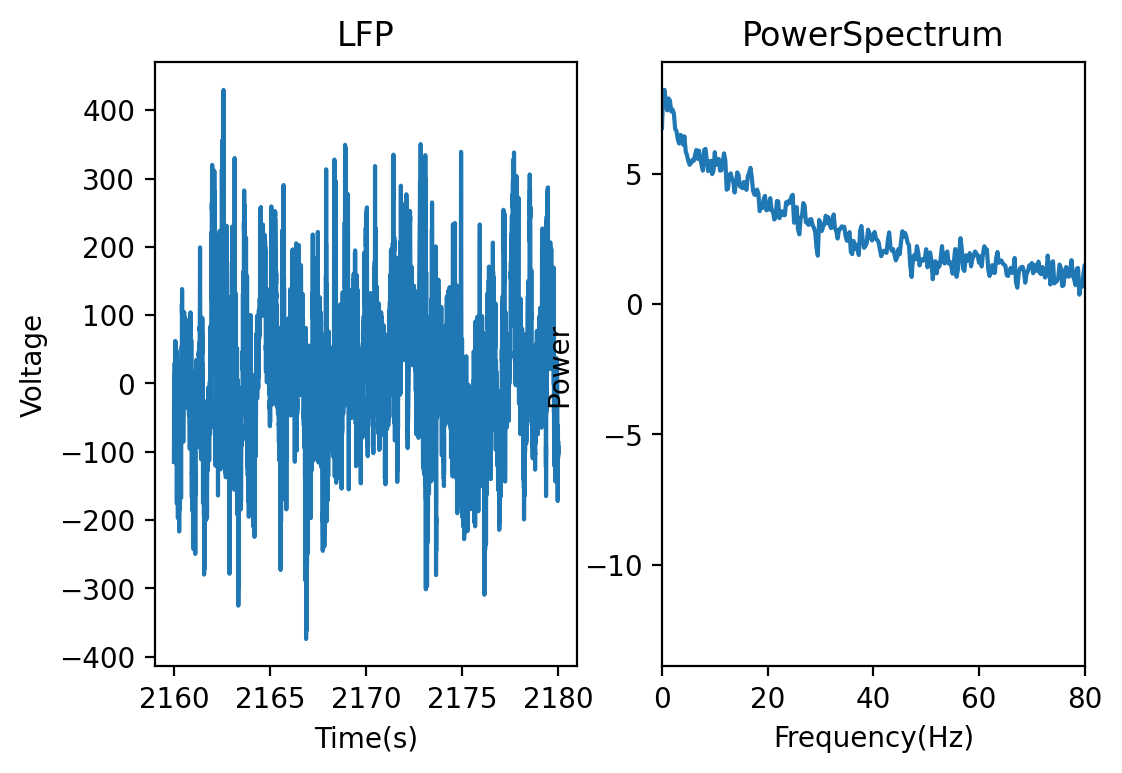

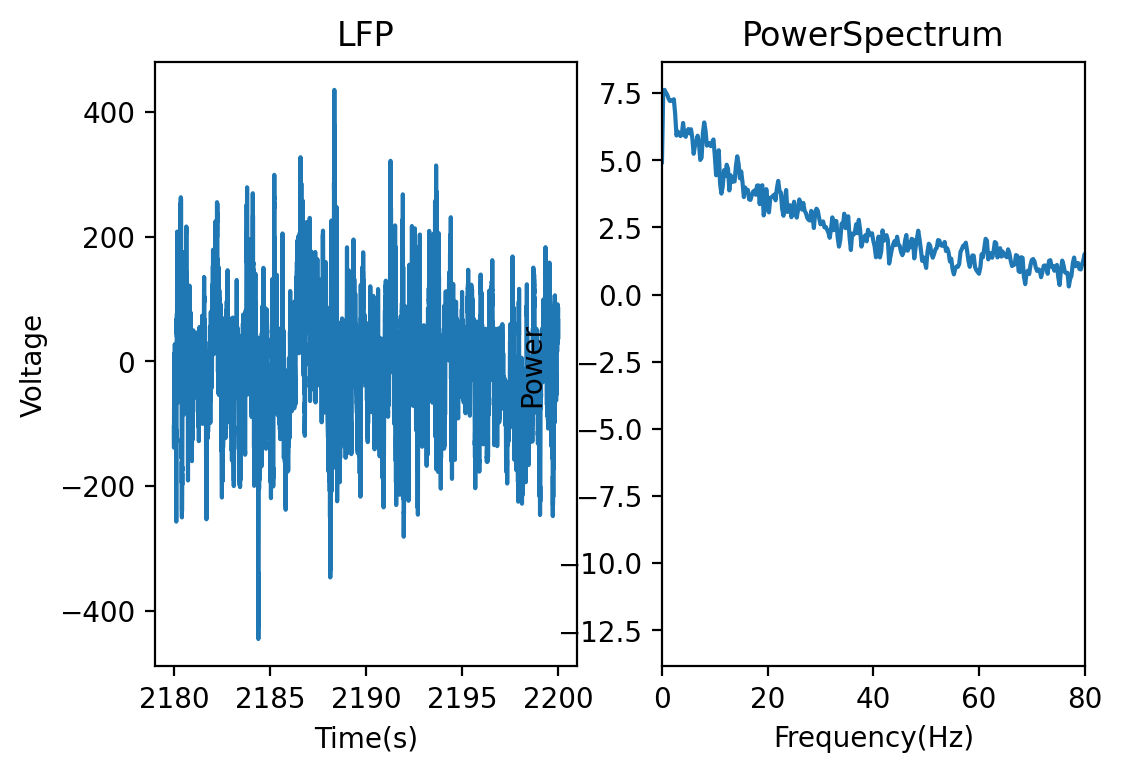

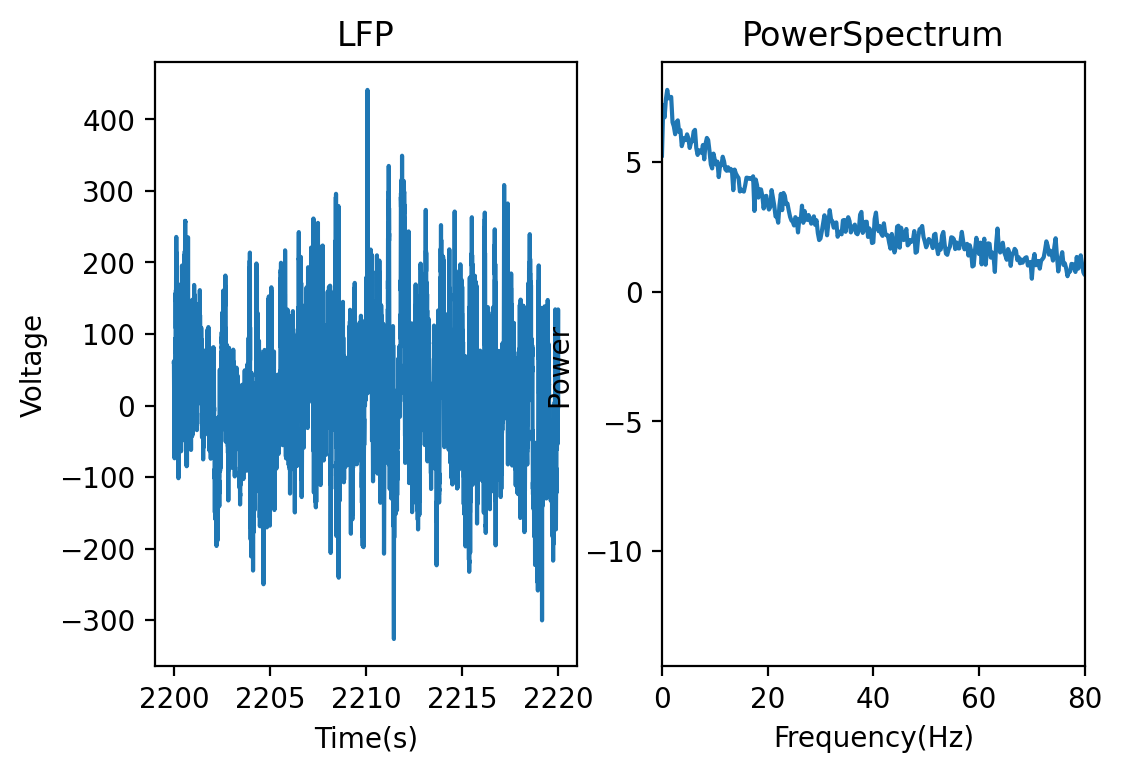

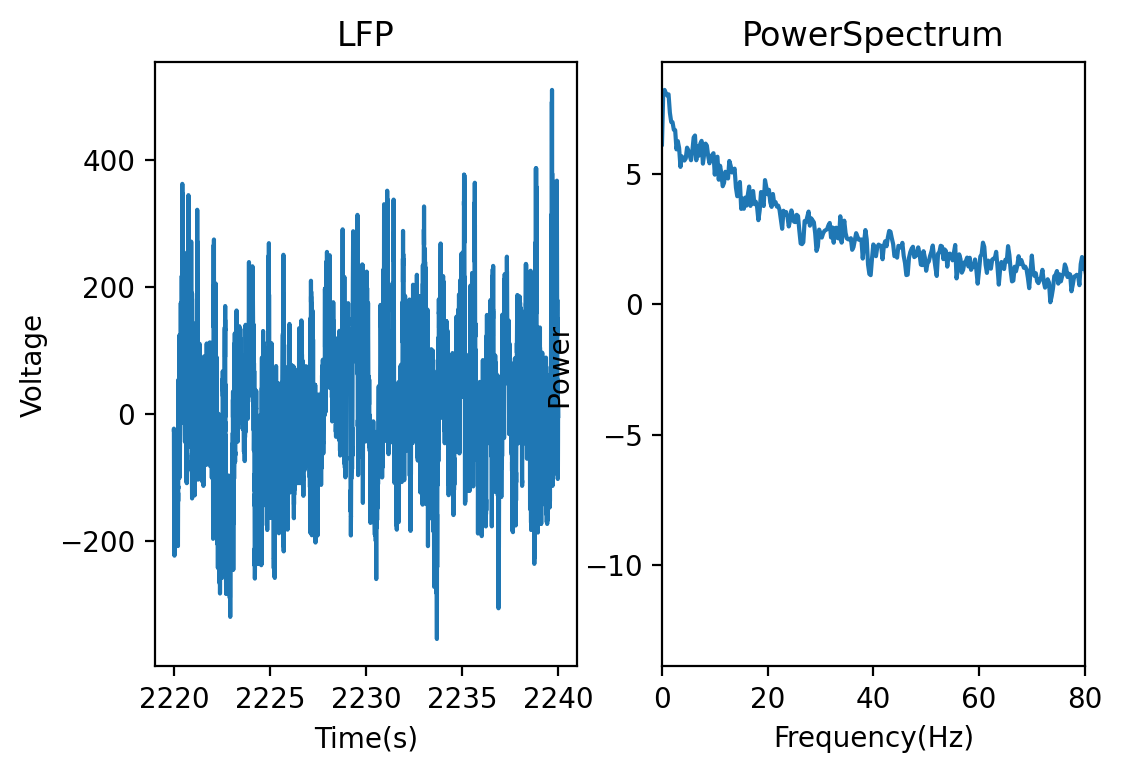

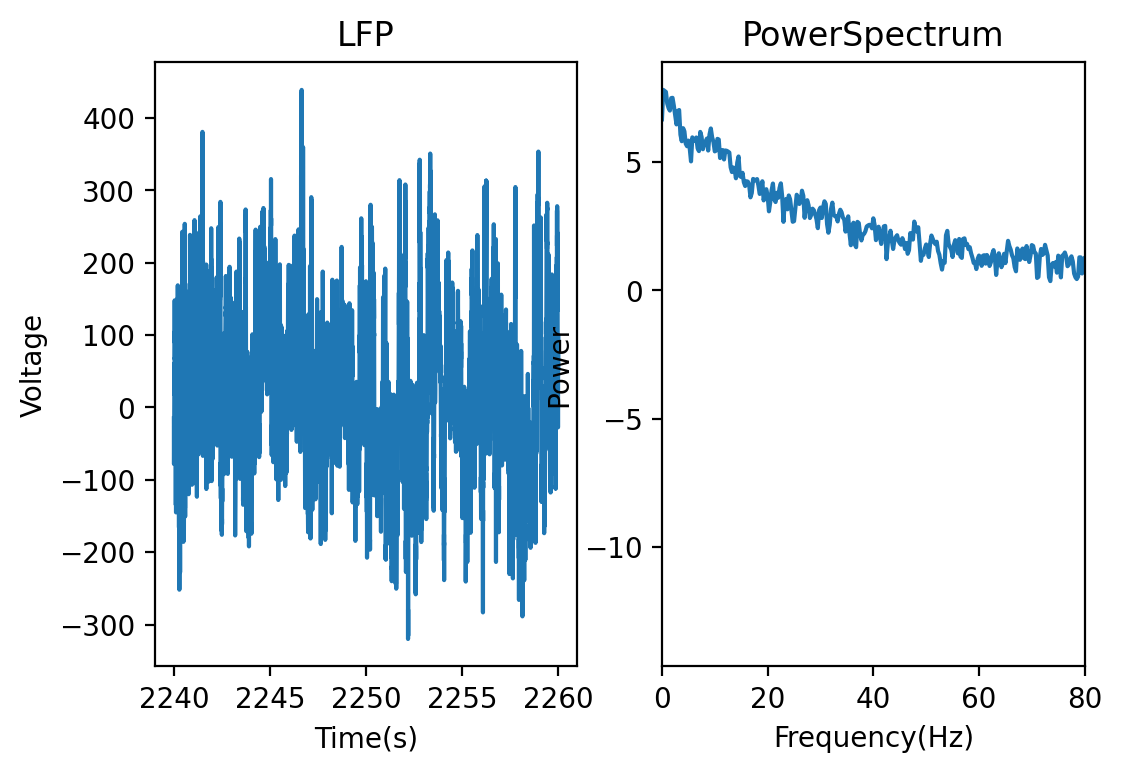

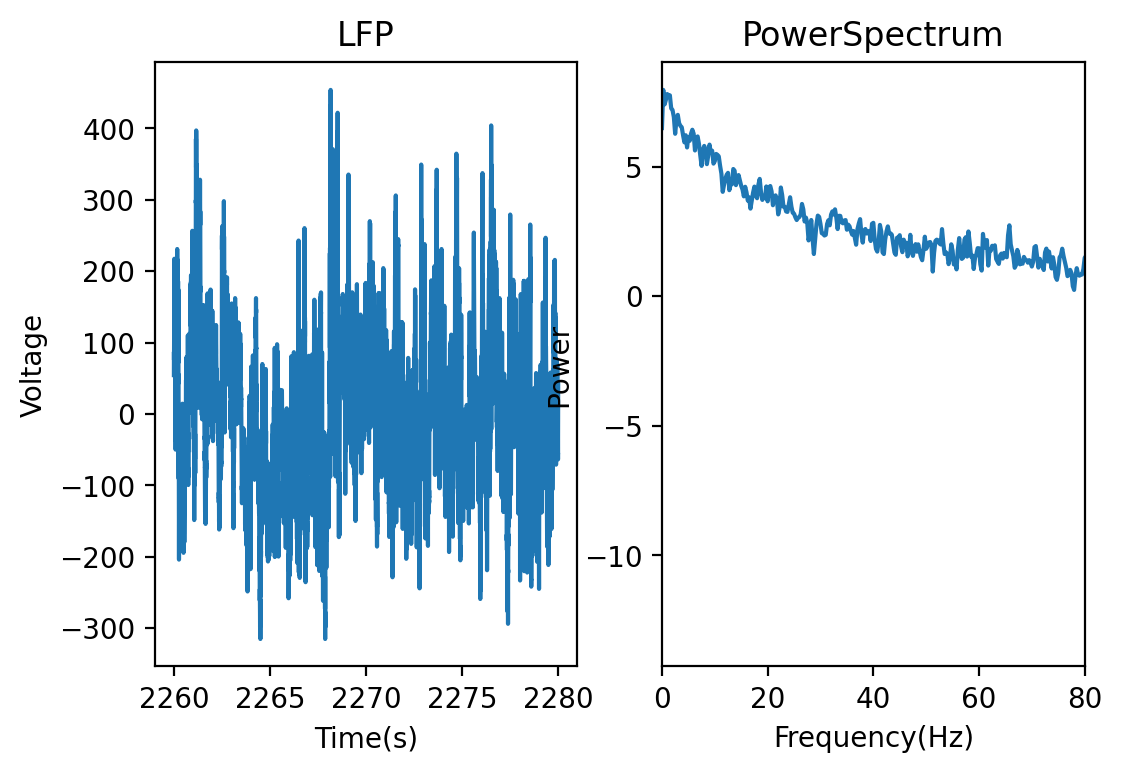

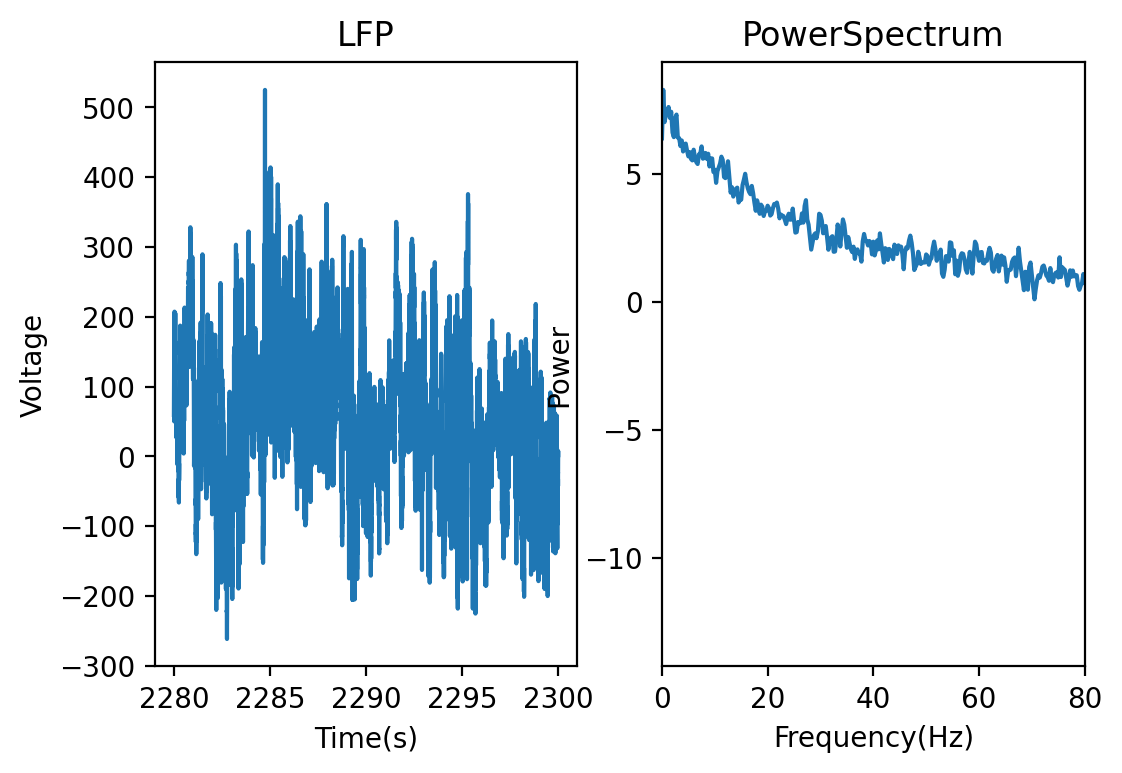

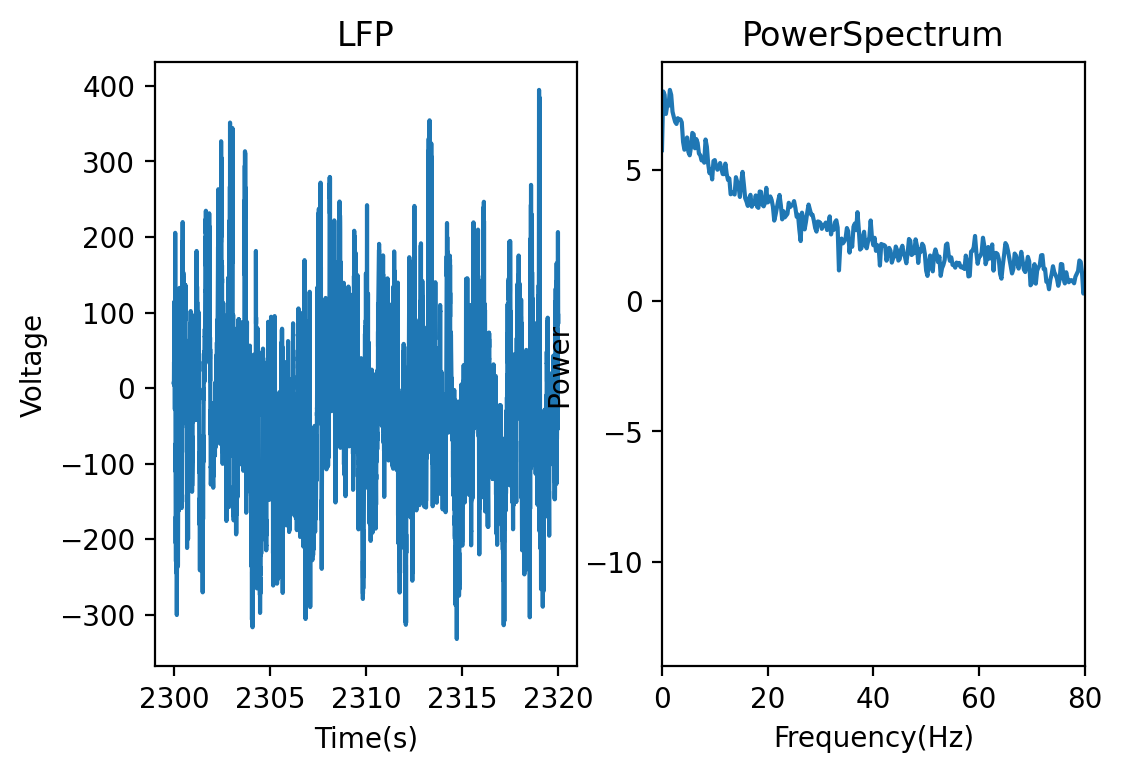

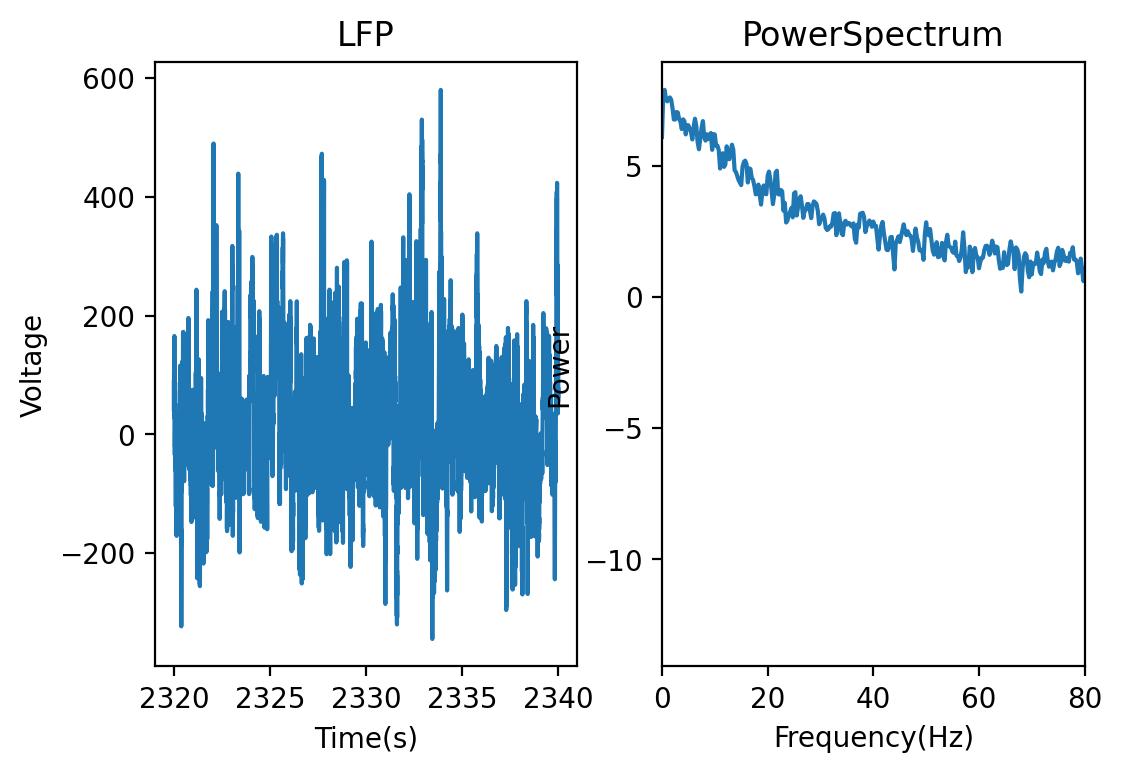

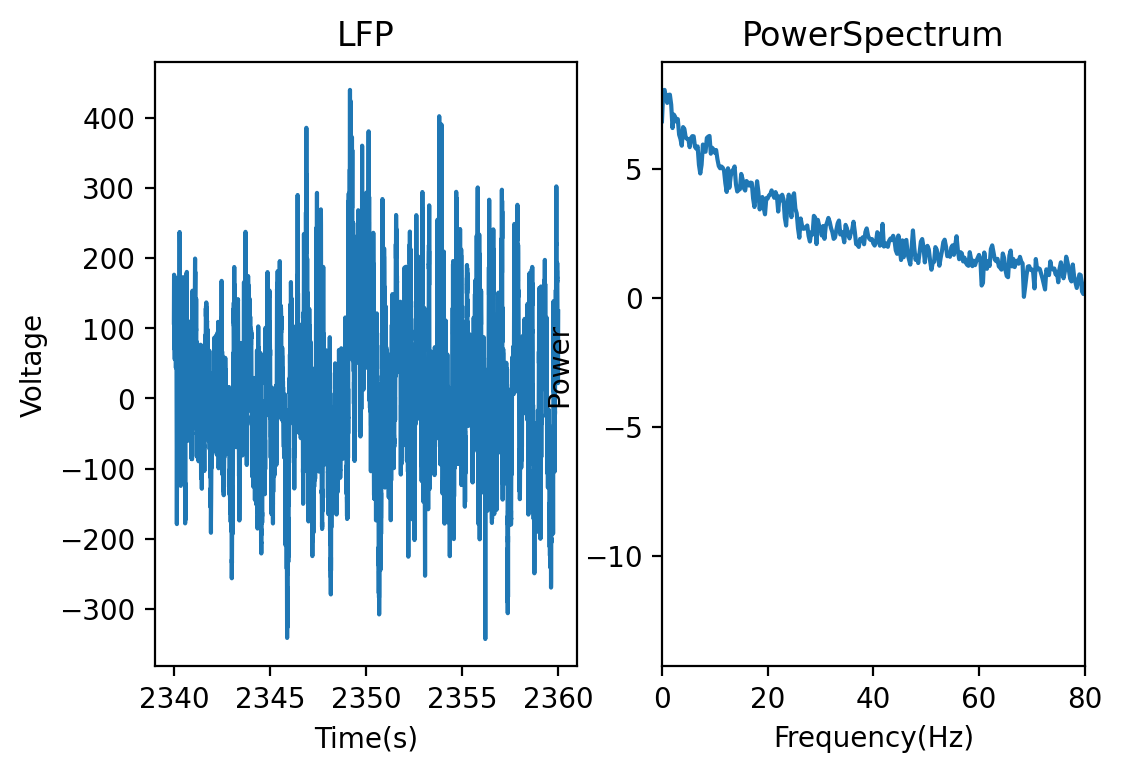

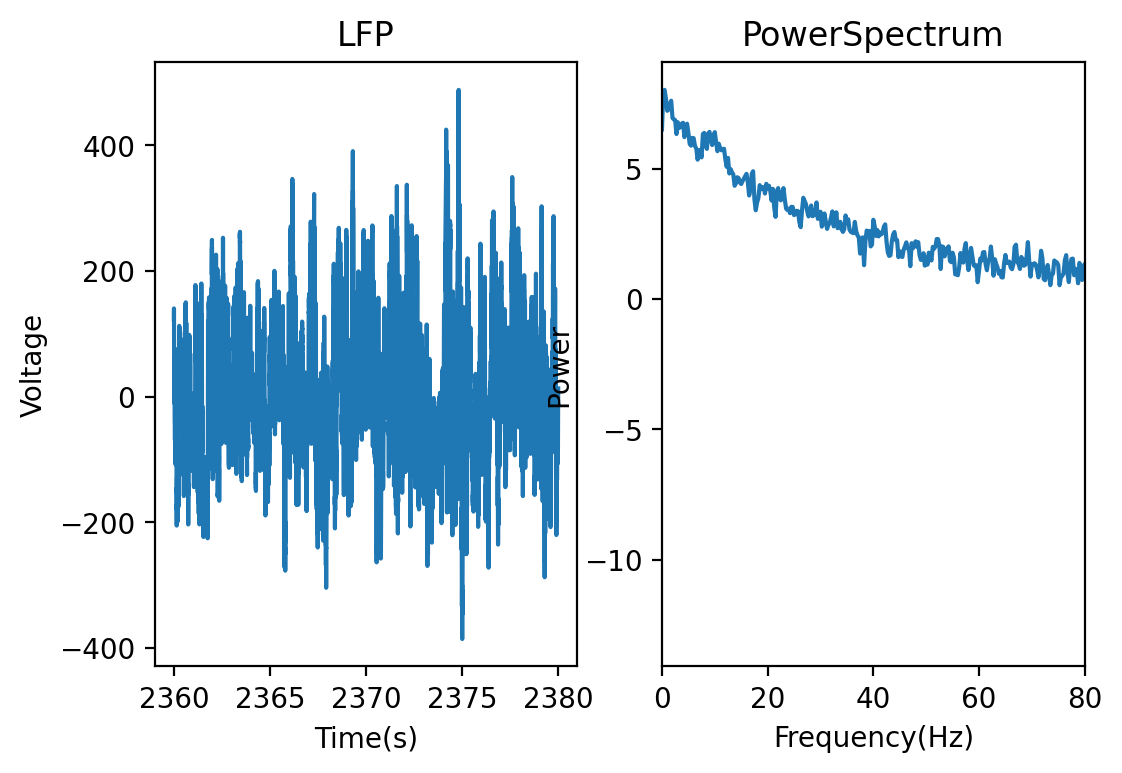

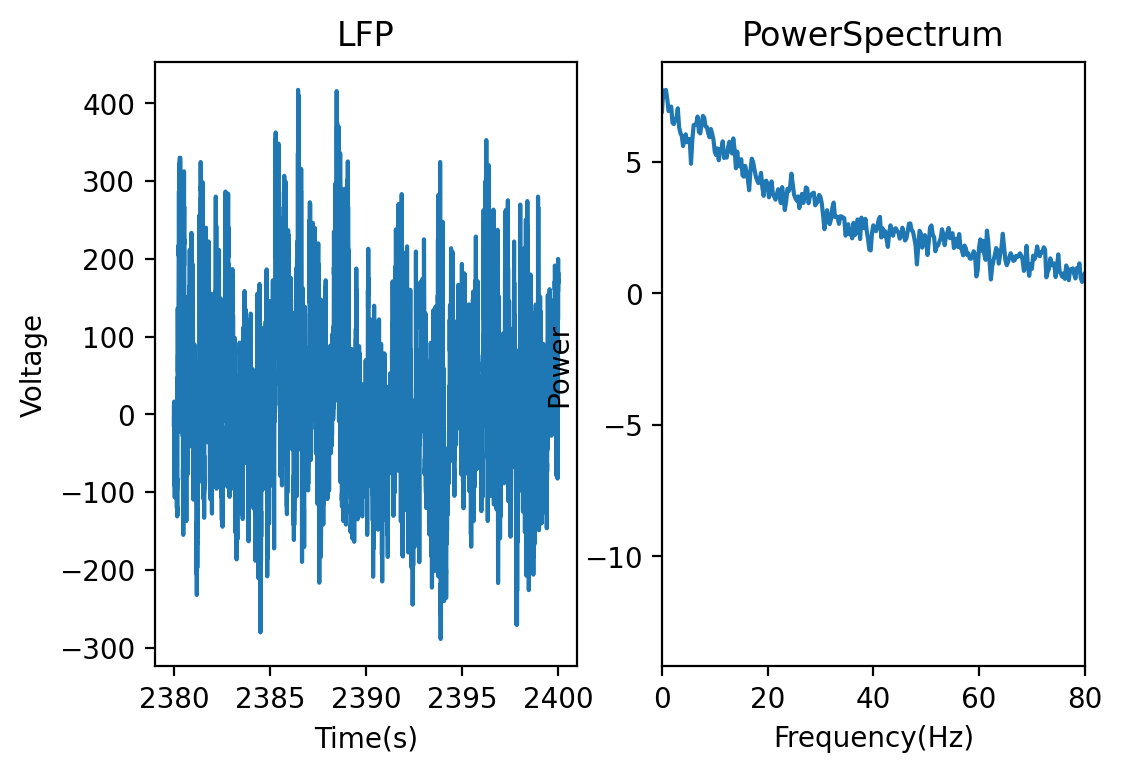

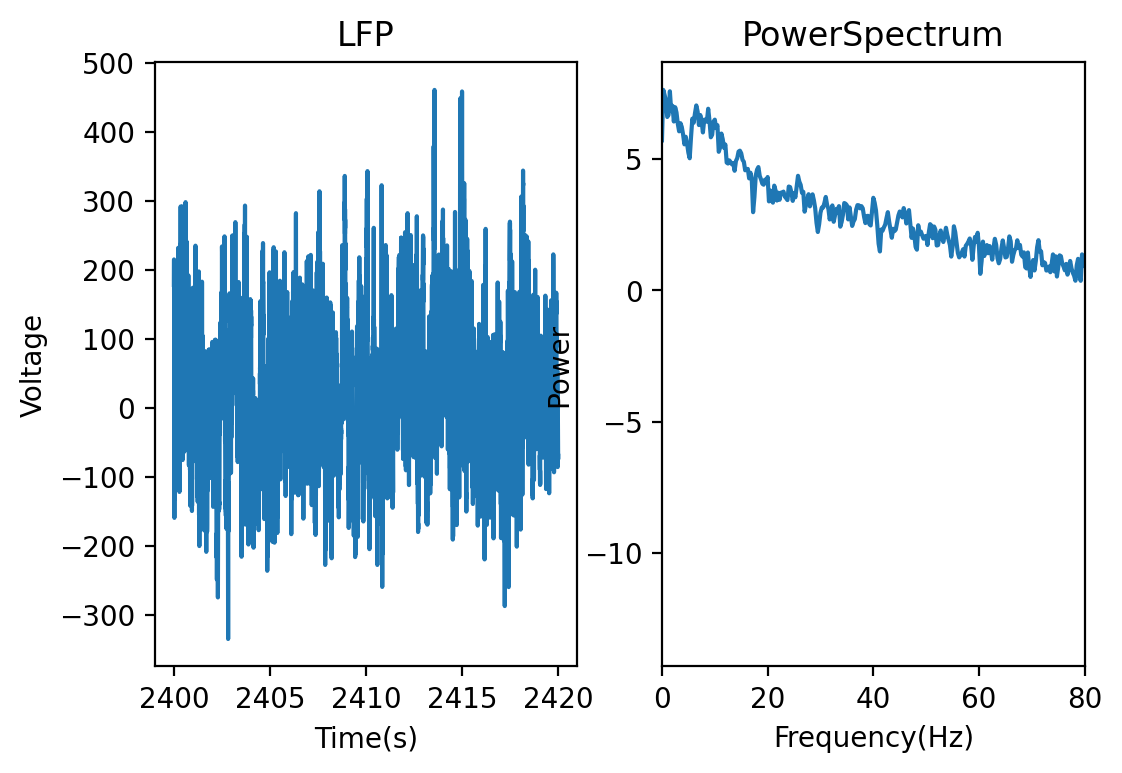

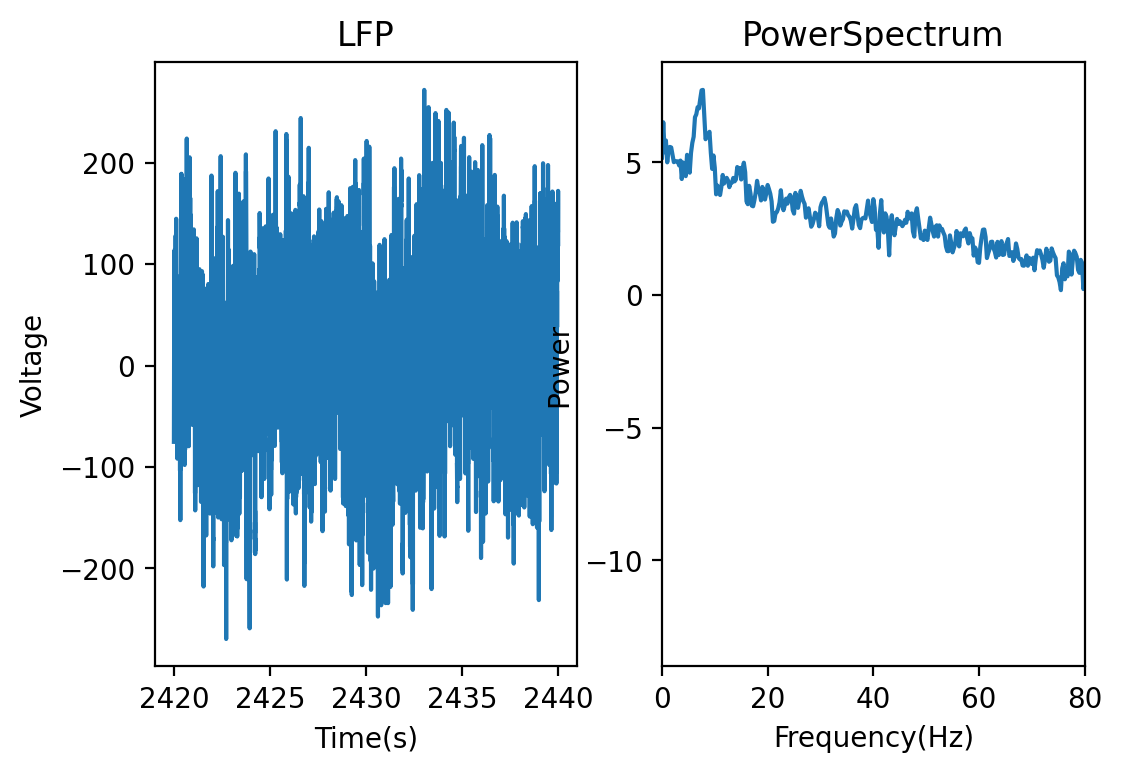

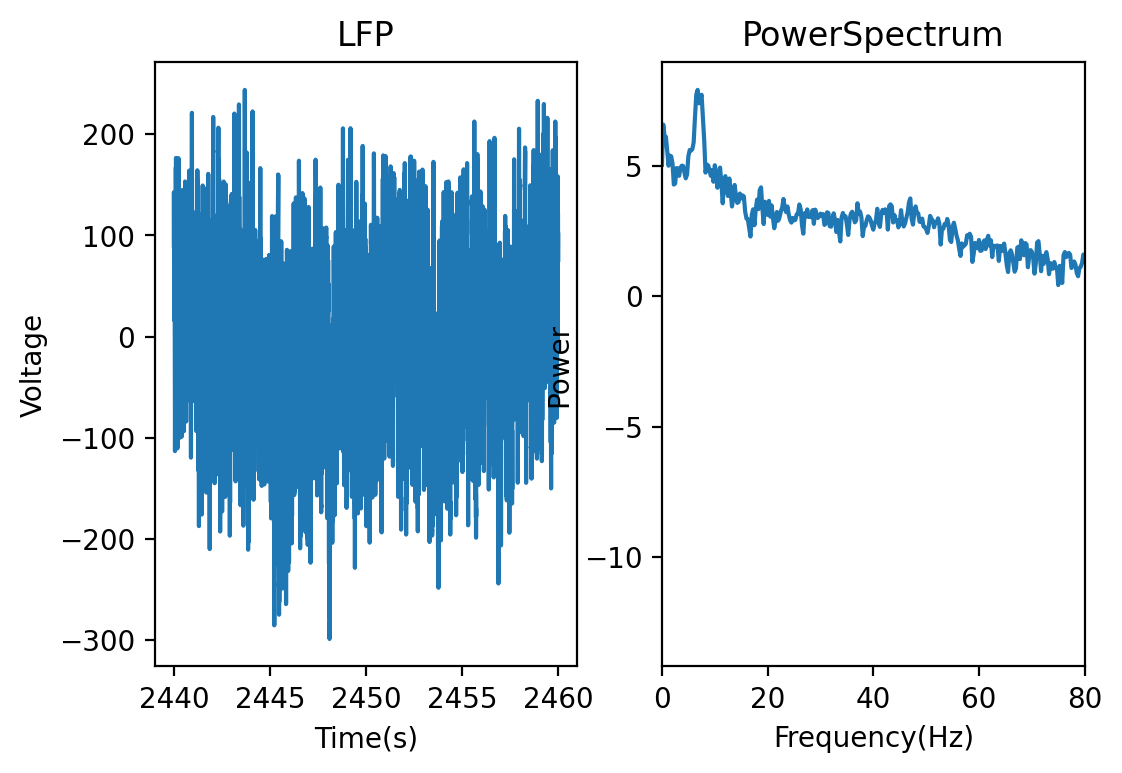

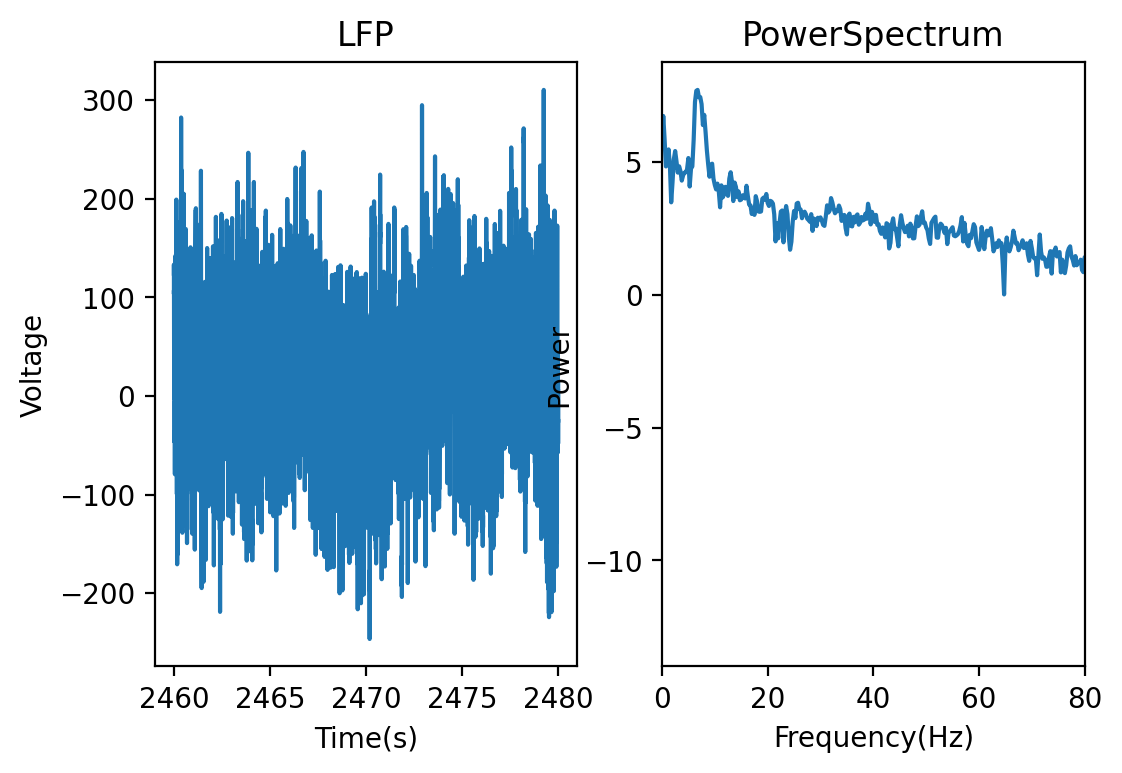

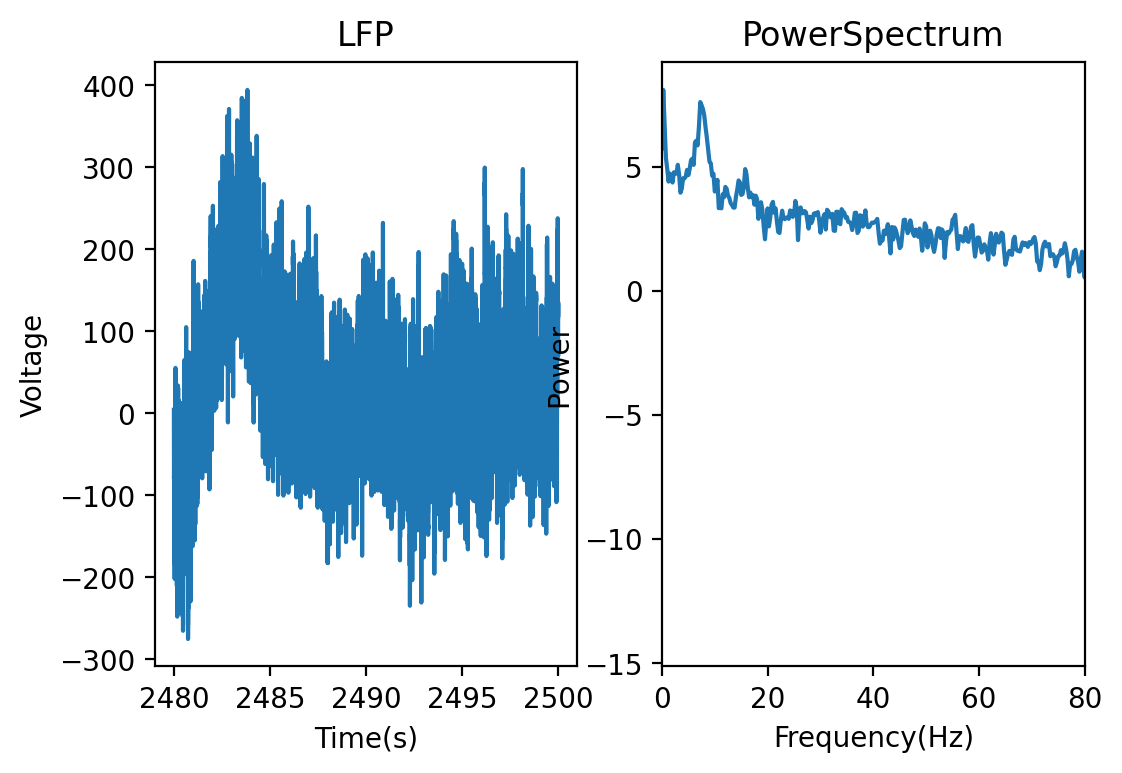

In [31]:
time_interval = np.arange(2100,2500,20)

for t in time_interval:
    lfp = bk.load.lfp(23,t,t+20)
    f, power = scipy.signal.welch(lfp.values,1250,nperseg=5000,noverlap=2500)
    fig,ax = plt.subplots(1,2,dpi = 200)


    ax[0].plot(lfp.as_units('s'))
    ax[0].set_title('LFP')
    ax[0].set_ylabel('Voltage')
    ax[0].set_xlabel('Time(s)')
    ax[1].plot(f,np.log(power))
    ax[1].set_title('PowerSpectrum')
    ax[1].set_ylabel('Power')
    ax[1].set_xlabel('Frequency(Hz)')
    plt.xlim(0,80)

In [23]:
states = bk.load.states()
automatic_state = bk.load.intervals('sleep_scoring_automatic')

In [28]:
%matplotlib qt
fig,ax = plt.subplots(2,1,sharex=True)
plt.sca(ax[0])

bk.plot.intervals(states['Rem'],'orange')
bk.plot.intervals(states['sws'],'grey')
bk.plot.intervals(states['wake'],'green')

plt.sca(ax[1])

bk.plot.intervals(automatic_state['REM'],'orange')
bk.plot.intervals(automatic_state['NREM'],'grey')
bk.plot.intervals(automatic_state['WAKE'],'green')

In [9]:
states = bk.load.states()

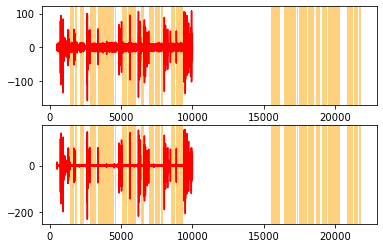

In [11]:
lfp_hpc = bk.load.lfp(23,500,10_000)
lfp_bla = bk.load.lfp(121,500,10_000)

filt_lfp_hpc = bk.signal.passband(lfp_hpc,100,300)
filt_lfp_bla = bk.signal.passband(lfp_bla,100,300)

ax = plt.subplot(2,1,1)
# plt.plot(lfp_hpc.as_units('s'),color = 'grey',alpha = 0.5)
hpc_zscore = sp.stats.zscore(filt_lfp_hpc.values)
bla_zscore = sp.stats.zscore(filt_lfp_bla.values)
plt.plot(filt_lfp_hpc.as_units('s').index,hpc_zscore,color = 'r')
bk.plot.intervals(states['sws'])



plt.subplot(2,1,2,sharex=ax)
# plt.plot(lfp_bla.as_units('s'),color = 'grey',alpha = 0.5)
plt.plot(filt_lfp_bla.as_units('s').index,bla_zscore,color = 'r')
bk.plot.intervals(states['sws'])

## PowerSpectrum / PowerSpectrograms

In [178]:
lfp_hpc = bk.load.lfp(0,20000,166,101)

In [179]:
states = bk.load.states()

lfp_rem = lfp_hpc.restrict(states['Rem'])
lfp_sws = lfp_hpc.restrict(states['sws'])

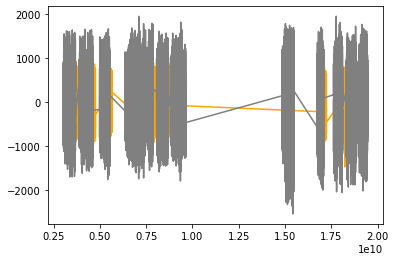

In [180]:
plt.plot(lfp_rem,'orange')
plt.plot(lfp_sws,'grey')

(0.0, 100.0)

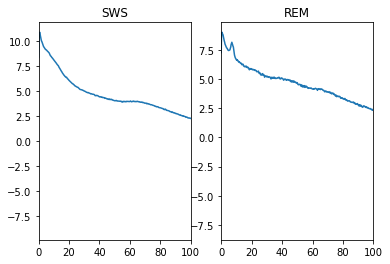

In [181]:
f,power_sws = sp.signal.welch(lfp_sws,1250,nperseg = 5000, noverlap=2500)
f,power_rem = sp.signal.welch(lfp_rem,1250,nperseg = 5000, noverlap=2500)

plt.subplot(1,2,1)
plt.title('SWS')
plt.plot(f,np.log(power_sws))
plt.xlim(0,100)

plt.subplot(1,2,2)
plt.title('REM')
plt.plot(f,np.log(power_rem))
plt.xlim(0,100)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


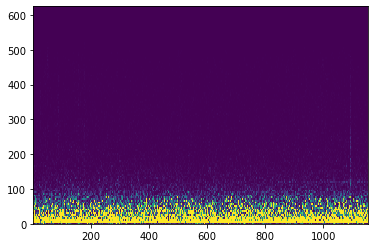

In [183]:
f,t,sxx = sp.signal.spectrogram(lfp_rem,1250,nperseg=250,noverlap=125)
plt.pcolormesh(t,f,sxx)
plt.clim(0,200)

# Spikes and Neurons


In [13]:
neurons,metadata = bk.load.spikes()

Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy


In [14]:
y = np.ones(len(neurons[0]))

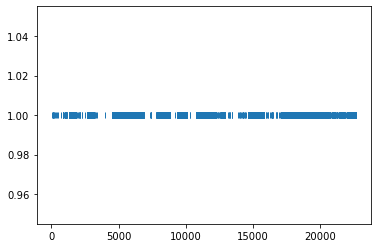

In [15]:
plt.plot(neurons[0].as_units('s').index,y,'|')

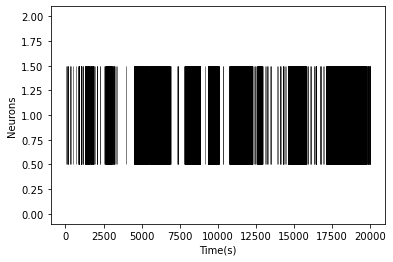

In [16]:
bk.plot.rasterPlot([neurons[0]],np.array([[0,20000]]))

# Behavior

In [17]:
pos = bk.load.pos()

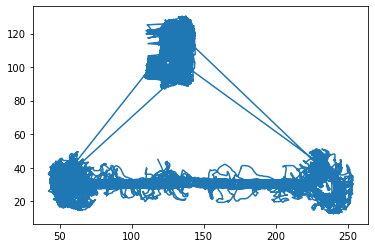

In [18]:
plt.plot(pos['x'],pos['y'])

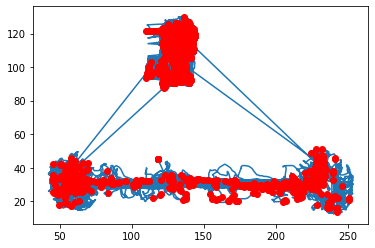

In [19]:
plt.figure()
pos_when_spike = pos.realign(neurons[13])
plt.plot(pos['x'],pos['y'])
plt.plot(pos_when_spike.as_units('s')['x'],pos_when_spike.as_units('s')['y'],'ro')

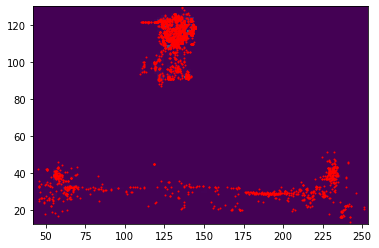

In [20]:
plt.figure()
plt.hist2d(pos['x'],pos['y'],bins = 100)
plt.plot(pos_when_spike.as_units('s')['x'],pos_when_spike.as_units('s')['y'],'ro',markersize = 1)

In [21]:
neurons[0].realign(pos).as_units('s')

Time (s)
9.0880       NaN
9.1136       NaN
9.1392       NaN
9.1648       NaN
9.1904       NaN
              ..
22679.8848   NaN
22679.9104   NaN
22679.9360   NaN
22679.9616   NaN
22679.9872   NaN
Length: 885173, dtype: float64

# Batching

# Conclusion